# 1. Import dependencies and Data

!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True )



In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# bringing our dependancies
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist',split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVT7K5Y/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVT7K5Y/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds2 = tfds.load('cifar10',split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteDLGCV5/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteDLGCV5/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
len(ds)

60000

# 2. Viz data and build dataset


In [ ]:
import numpy as np

In [ ]:
# setup connection aka iterator
data_iterator = ds.as_numpy_iterator()

In [ ]:
#getting data via pipeline
data_iterator.next()

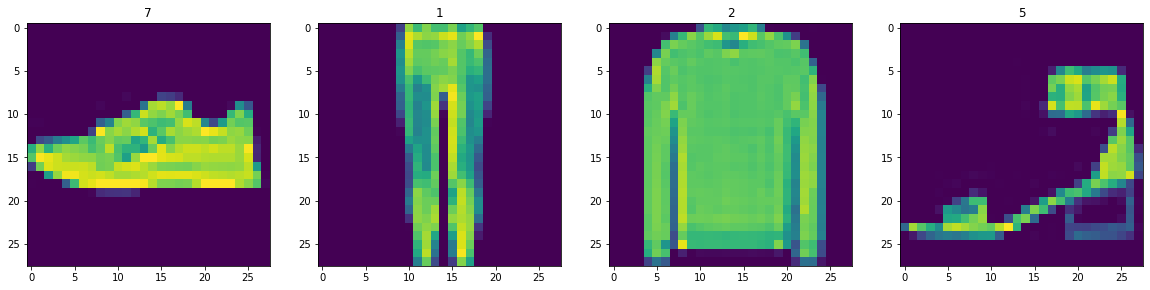

In [ ]:
# setup the subplot format
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
# loop 4 times and get images
for idx in range(4):
    #grab an image and label
    batch = data_iterator.next()
# plot the image using specific subplot
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [ ]:
ax[2].imshow(batch['image'])


In [ ]:
#scale and return the image only
def scale_images(data):
    image = data['image']
    print(type(image))
    return image /255


In [ ]:
ds = ds.map(scale_images)
#caching the dataset in order to faster njyboha
ds = ds.cache()
ds = ds.shuffle(60000)
#batching the dataset
ds = ds.batch(256)
# reduce the likelihood of bottlenecking
# prefetching data means preparing the next batch while the current batch is already in work
ds = ds.prefetch(256)



<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
ds.as_numpy_iterator().next().shape

(256, 28, 28, 1)

# 3. Build Neural Network

## 3.1 import the model components

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, Dense , Reshape , Flatten , UpSampling2D, LeakyReLU, Dropout, BatchNormalization,Conv2DTranspose
from tensorflow.keras.initializers import RandomNormal
init = RandomNormal(mean=0.0, stddev=0.02)

## 3.2 Build the generator model

In [ ]:
def build_generator_2():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim =128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    # upsampling 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    #upsampling 2

    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    #convolutional 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    #convolutional 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    #activation
    model.add(Conv2D(1,4, padding='same', activation ='sigmoid'))

#    model.add(UpSampling2D())
 #   model.add(Conv2D(1,5,padding='same'))
  #  model.add(LeakyReLU(0.2))
#    model.add(Reshape(14,14,256))

    return model

In [ ]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_dim = 128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1),kernel_initializer=init, padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2),kernel_initializer=init, padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2),kernel_initializer=init, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

we're going to change tomorrow the upsampling + conv2d with conv2sTranspose for better results


In [ ]:
build_generator().summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12544)             1605632   
                                                                 
 batch_normalization_25 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_26 (Bat  (None, 7, 7, 128)       

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
generator = build_generator()

In [ ]:
img =generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 122ms/step


(4, 28, 28, 1)

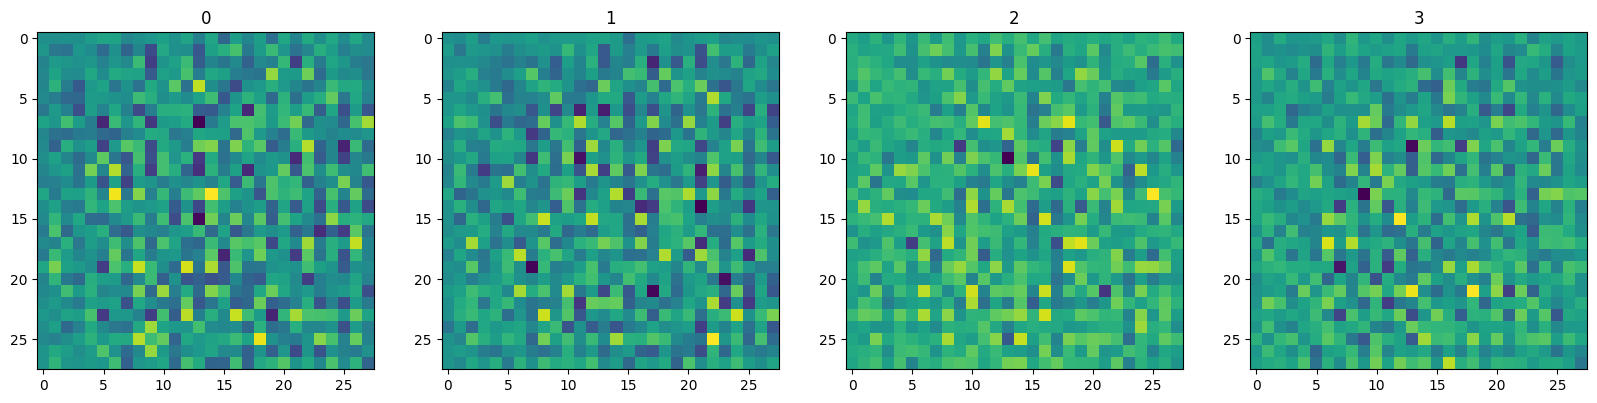

In [ ]:
# setup the subplot format
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
# loop 4 times and get images
for idx,img2 in enumerate(img):

# plot the image using specific subplot
    ax[idx].imshow(np.squeeze(img2))
    ax[idx].title.set_text(idx)

## 3.3 Build the discriminator model

In [ ]:
def build_discriminator():
    model = Sequential()
    # building the first block requires giving the input shape
    model.add(Conv2D(32,5,input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # building the rest of blocks doesn't requires the input shape
    # building the second conv block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # building the third conv block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # building the fourth conv block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # building the fifth conv block
    #model.add(Conv2D(512,5))
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(0.2))
    #model.add(Dropout(0.4))

    # flatten and give to a dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation ='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)      

In [ ]:
discriminator(img)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.9617756 ],
       [0.92968357],
       [0.96960753],
       [0.9551061 ]], dtype=float32)>

# 4. Construct Training loops


## 4.1 Setup losses and optimizers


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt =Adam(learning_rate = 0.0001,beta_1 = 0.5)
d_opt = Adam(learning_rate =  0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy ()

In [ ]:
import os
from tensorflow.python import checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer= g_opt,
                                 discriminator_optimizer = d_opt,
                                 generator= generator,
                                 discrimintaor = discriminator)
# we use this to check the process of our work checkpoint for saving and restoring the weights of your model and optimizers during training. Checkpoints are useful for saving the state of your model at various intervals during training, allowing you to resume training from a specific checkpoint or use the saved weights for inference later.



## 4.2 Build Subclassed Model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
tf.random.normal((6,128,1))

In [ ]:
class FashionGan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # create an attribute for our generator and discriminator
        self.generator = generator
        self.discriminator= discriminator
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt= g_opt
        self.d_opt=d_opt
        self.g_loss= g_loss
        self.d_loss= d_loss
    def train_step(self,batch):
        #get the data
        real_images = batch
        # 128 is the same number as the number of the of images in each batch
        fake_images= self.generator(tf.random.normal((128,128,1)), training = False)

        #train the discriminator
        with tf.GradientTape() as d_tape:
        # passs the real and the fake images to the discriminator
            yhat_real = self.discriminator(real_images, training = True )
            yhat_fake = self.discriminator(fake_images, training = True )
            yhat_real_fake = tf.concat([yhat_real,yhat_fake],axis= 0)
        # create label for fake and real images
            y_real_fake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)
        # add some noise to the output ( this helps it to learn a bit slower)
            noise_real = 0.15* tf.random.uniform(tf.shape(yhat_real))
            noise_fake= -0.15* tf.random.uniform(tf.shape(yhat_fake))
            y_real_fake += tf.concat([noise_real,noise_fake],axis=0)
        # calculate the loss
            d_total_loss = self.d_loss(y_real_fake, yhat_real_fake)
        # apply backpropagation
        dgrad = d_tape.gradient(d_total_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # train the generator
        with  tf.GradientTape() as g_tape  :
            # generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)),training = True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_images, training =  False)

            # calculate the loss - trick to training to fake the discriminator
            g_total_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)
        #apply backpropagation
        ggrad= g_tape.gradient(g_total_loss, self.generator.trainable_variables )
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'total_d_loss': d_total_loss, 'g_total_loss': g_total_loss}




In [ ]:
# Create an instance of our subclass model
FashGan = FashionGan(generator, discriminator)

In [ ]:
# compile our model
FashGan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build Call Back

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img = 3, latent_dim = 128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs = None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images',f'generated_img_{epoch}_{i}.png'))

## 4.4 Train

In [ ]:
hist = FashGan.fit(ds, epochs = 300, callbacks= [ModelMonitor()])

Epoch 1/300
  6/235 [..............................] - ETA: 26s - total_d_loss: 0.3649 - g_total_loss: 1.9620

235/235 [==============================] - 31s 110ms/step - total_d_loss: 0.3530 - g_total_loss: 2.0265
Epoch 2/300
235/235 [==============================] - 25s 108ms/step - total_d_loss: 0.3524 - g_total_loss: 2.2379
Epoch 3/300
235/235 [==============================] - 25s 106ms/step - total_d_loss: 0.3588 - g_total_loss: 2.0322
Epoch 4/300
235/235 [==============================] - 25s 107ms/step - total_d_loss: 0.3519 - g_total_loss: 2.0394
Epoch 5/300
235/235 [==============================] - 25s 108ms/step - total_d_loss: 0.3553 - g_total_loss: 1.9179
Epoch 6/300
235/235 [==============================] - 25s 108ms/step - total_d_loss: 0.3502 - g_total_loss: 1.9091
Epoch 7/300
235/235 [==============================] - 25s 107ms/step - total_d_loss: 0.3531 - g_total_loss: 2.0475
Epoch 8/300
235/235 [==============================] - 26s 108ms/step - total_d_loss: 0.3487 - g_total_loss: 1.7256
Epoch 9/300
235/235 [==============================] - 25s 106ms/step - total_d_loss

## 4.5 Performance review

In [ ]:
hist.history

{'total_d_loss': [0.35696500539779663,
  0.37534764409065247,
  0.33986696600914,
  0.3207848370075226,
  0.3753202557563782,
  0.3441604673862457,
  0.3518838882446289,
  0.37675994634628296,
  0.3538665175437927,
  0.367216557264328,
  0.3595152497291565,
  0.32642459869384766,
  0.34398695826530457,
  0.32150155305862427,
  0.33726558089256287,
  0.3410148024559021,
  0.3399195075035095,
  0.33568429946899414,
  0.33139657974243164,
  0.33988502621650696,
  0.3591468036174774,
  0.32517486810684204,
  0.36879023909568787,
  0.3496682643890381,
  0.35509994626045227,
  0.3603132665157318,
  0.34969717264175415,
  0.3675134778022766,
  0.4190402925014496,
  0.34330978989601135,
  0.3876056373119354,
  0.3551802635192871,
  0.38094186782836914,
  0.3766220211982727,
  0.3790490925312042,
  0.3509540855884552,
  0.33626192808151245,
  0.34352728724479675,
  0.37136945128440857,
  0.3826964497566223,
  0.3851335644721985,
  0.3562079071998596,
  0.38266971707344055,
  0.34542322158813477

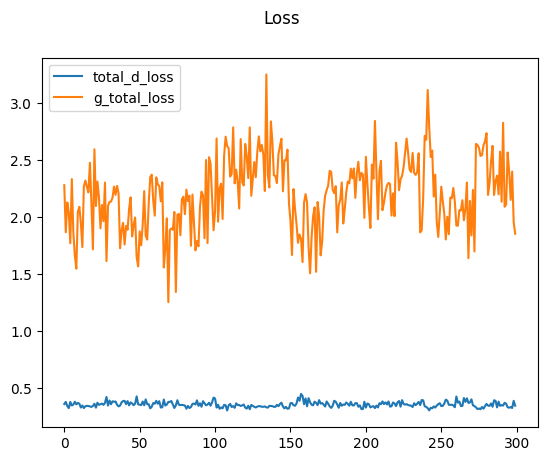

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['total_d_loss'], label='total_d_loss' )
plt.plot(hist.history['g_total_loss'], label= 'g_total_loss')
plt.legend()
plt.show()

# 5 Test out the generator


## 5.1 Generate images

In [ ]:
imgs = generator.predict(tf.random.normal((16,128,1)))


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


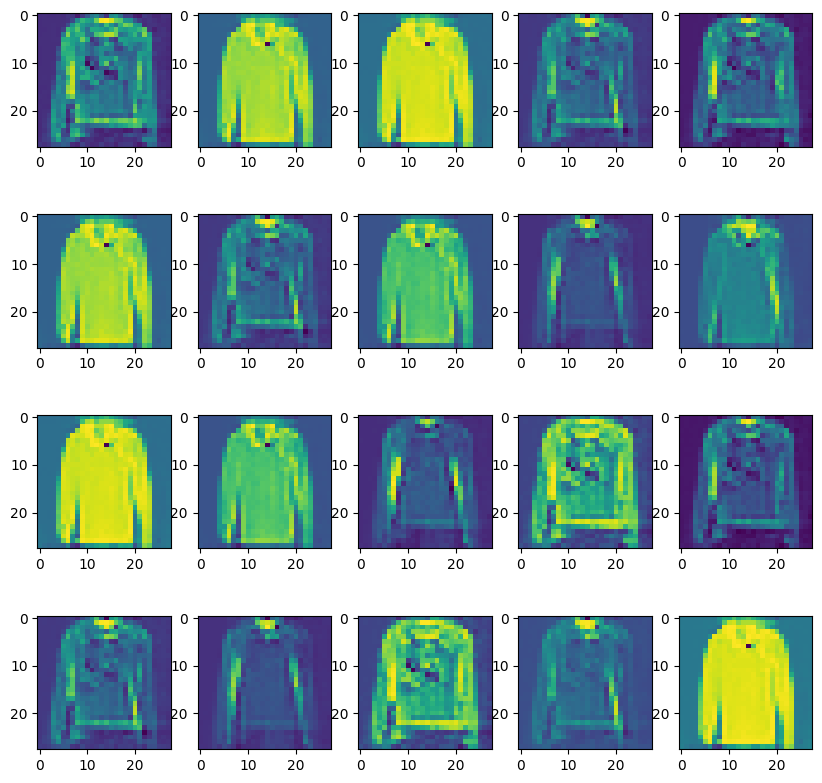

In [ ]:
imgs = generator.predict(tf.random.normal((20,128,1)))
fig , ax = plt.subplots(ncols = 5 , nrows =  4 , figsize = (10,10))
for i in range(4):
  for c in range(5):
    ax[i][c].imshow(imgs[(i+1)*(c+1)-1])


## 5.2 Save and load the model


In [ ]:
# Load the model
#generator.load_weights()
# save the model
generator.save('generator.h5')
discriminator.save('discriminator.h5')